```
Created on Wed June 18 2025

@author: Arjun Chakrawal
@contact: arjun.chakrawal@pnnl.gov

```

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
#%%
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.ticker as mtick

# soil_wat_bal: Soil water balance function
from soil_hydrology_module import soil_wat_bal

# mll: Millennial model functions and steady-state calculations
import millennial_module as mll

# ms: MEMES_functions, e.g., generate_forcings for climate/plant input
import MEMES_functions as ms


## Load soil hydraulic properties

In [3]:
soil_texture = pd.read_excel('soil_texture.xlsx')
soil_texture = soil_texture[soil_texture['source'].isin(['Intact', 'Repacked','HiHydroSoil v2.0'])].copy()

## Figure 1

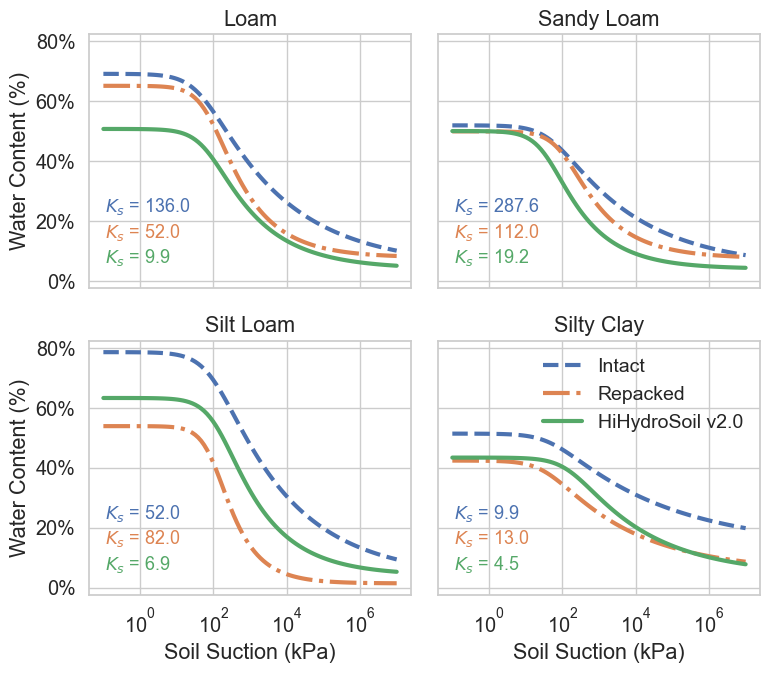

In [4]:
# Define the Van Genuchten function
def van_genuchten(h, alpha, n, theta_r, theta_s):
    return theta_r + (theta_s - theta_r) / ((1 + (alpha * np.abs(h))**n)**(1 - 1/n))

# Generate pressure head values on a log scale
h_vals = np.logspace(-1, 7, 100)

#% Create subplots

sns.set_theme(style="whitegrid", font_scale=1.3)

soil_types = ['Loam', 'Sandy Loam', 'Silt Loam', 'Silty Clay']
lstyle = {"Intact": "--", "Repacked": "-.", "HiHydroSoil v2.0": "-"}
sources= ["Intact", "Repacked","HiHydroSoil v2.0"]
# Create subplots
fig, axes = plt.subplots(2, 2, figsize=(8, 7), sharex=True, sharey=True)
axes = axes.flatten()

for ax, soil in zip(axes, soil_types):
    # Filter data for the given soil texture
    subset = soil_texture[soil_texture['texture'] == soil]
    
    # Group by 'source' and plot each
    for i, source in enumerate(sources):
        group = subset[subset['source']==source]
        # Extract parameters
        theta_r = group['theta_r'].values[0]
        theta_s = group['theta_s'].values[0]
        alpha = group['alpha'].values[0]
        n = group['n'].values[0]
        m = group['m'].values[0]
        ksat = group['KSAT_cm_day'].values[0]

        # Compute water retention curve
        theta = van_genuchten(h_vals, alpha, n, theta_r, theta_s)
        # Plot
        line, = ax.plot(h_vals, theta, label=source, linewidth=3, linestyle=lstyle[source])
        # Annotate with KSAT value
        color = line.get_color()
        x_annot = h_vals[int(len(h_vals)*0.75)]
        y_annot = theta[int(len(h_vals)*0.5)]
        ax.text(0.05, 0.3-i*0.1,
                    f"$K_s$ = {ksat:.1f}",
                    transform=ax.transAxes,
                    fontsize=13,
                    color=line.get_color())

    ax.set_xscale("log")
    ax.set_title(soil)
    ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1))

ax.legend(loc="best", fontsize=14, frameon=False)
axes[2].set_xlabel("Soil Suction (kPa)")
axes[3].set_xlabel("Soil Suction (kPa)")

axes[0].set_ylabel("Water Content (%)")
axes[2].set_ylabel("Water Content (%)")
plt.tight_layout()
plt.savefig("figs/WRC_HyProp.png", dpi=300, bbox_inches='tight')
plt.savefig("figs/WRC_HyProp.svg", bbox_inches='tight')
plt.show()

## Figure 2: Soil C cycle modeling

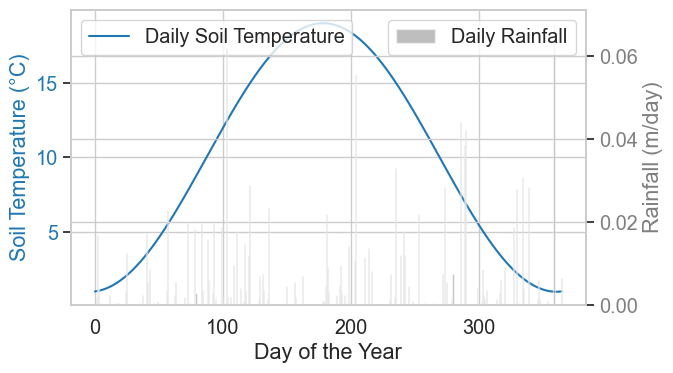

328.68557479470576

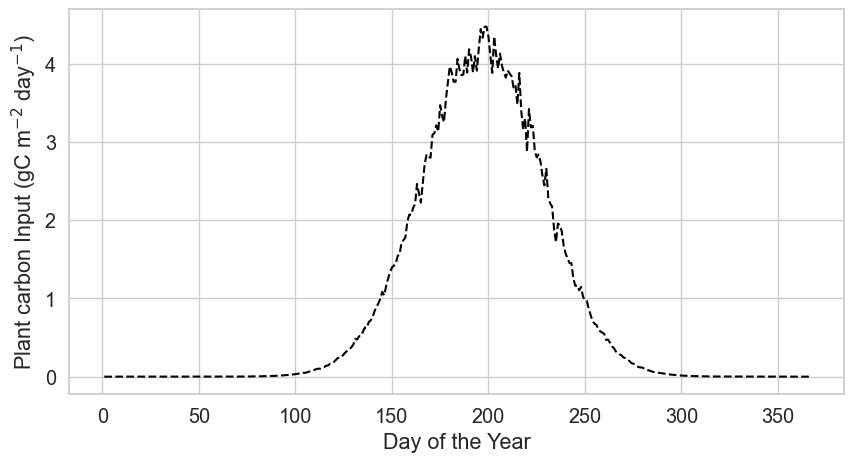

In [5]:
# %% Read inputs
new_coloc= 2
soil_dict, kinetic_dict, soil_texture=mll.load_par()

rainfall, daily_soil_temperatures, total_plant_input = ms.generate_forcings(generate_plot=True)
total_plant_input.sum()

In [6]:
def get_daily_respiration(new_coloc=new_coloc, default_moisture=False):
    pool_order = ["POM [gC m-2]", "LMWC [gC m-2]", "AGG [gC m-2]", "MIC [gC m-2]", "MAOM [gC m-2]"]

    # Millennial model moisture sensitivity
    ss_millennial=mll.ss_bar_chart(new_coloc=new_coloc,default_moisture=default_moisture, make_plot=False) 
    moisture = []
    results= []
    ss_results = []
    for _, row in soil_texture.iterrows():
        # Extract soil parameters for the current row
        if  row['source']=='Repacked':
            coloc_factor= new_coloc # Intact soils would have more isolation, higher coloc_factor more isolation
        else:
            coloc_factor=soil_dict['coloc_factor']  #Repacked soils would have less isolation
        
        soil_dict_temp = soil_dict.copy()
        
        soil_dict_temp.update({
            'sand_pct': row['Sand'],
            'silt_pct': row['Silt'],
            'clay_pct': row['Clay'],
            'phitex': row['theta_s'],  # Assuming porosity corresponds to theta_s
            'swilt': row['theta_r'],   # Assuming wilting point corresponds to theta_r
            'kstex': row['KSAT_cm_day'] * 1e-2,  # Convert from cm/day to m/day 
            'm': row['m'],
            'coloc_factor': coloc_factor,
            'rel_opt_theta':row['Relative_opt_water_content'],
            'b': row['b']
        })
    
    
        SWB = np.zeros((len(rainfall), 5))
        s=0.2
        for i in range(len(rainfall)):
            result = soil_wat_bal(s, 1,  rainfall[i], soil_dict_temp)
            s = result[0]
            SWB[i] = result
    
        SWB_df = pd.DataFrame(SWB)
        SWB_df.columns = ['theta', 'Rain (m/d)', 'Runoff (m/d)', 'ET (m/d)', 'Kh (m/d)']
        SWB_df['time [day]'] = np.arange(len(rainfall))
    
        forcing_var = pd.DataFrame({'forc_st': daily_soil_temperatures,
                                    'forc_sw': SWB_df['theta'],
                                    'forc_npp': total_plant_input
                                    })
      
        sol = ss_millennial[(ss_millennial['Soil texture'] == row['texture']) & 
                            (ss_millennial['Source'] == 'Intact')]
        
        sol = sol[pool_order].values.flatten()
    
        # sol, eig = mll.cal_steady_state(forcing_var, kinetic_dict, soil_dict_temp, calc_eigen=True)
    
        # Run the model for this soil type
        output, fluxes = mll.dynamic_simulation(forcing_var, kinetic_dict, soil_dict_temp,
                                    state={'POM': sol[0], 'LMWC': sol[1], 'AGG': sol[2],
                                           'MIC': sol[3], 'MAOM': sol[4], 'CO2': 0}, SS=False, 
                                    default_moisture=default_moisture)
    
        resp = fluxes.f_MB_atm.values
    
        output['Respiration'] = resp
        output['Soil texture'] = row['texture']
        output['Source'] = row['source']
        if default_moisture:
            output['moisture_func'] = "Millennial"
        else:
            output['moisture_func'] = "Yan et al. (2018)"
        SWB_df['Soil texture'] = row['texture']
        SWB_df['Source'] = row['source']

        ss_output = pd.DataFrame([{
            'POM [gC m-2]': sol[0],
            'LMWC [gC m-2]': sol[1],
            'AGG [gC m-2]': sol[2],
            'MIC [gC m-2]': sol[3],
            'MAOM [gC m-2]': sol[4]
        }])
        

        # Add metadata columns for soil type, texture, and source
        ss_output['Soil Type'] = row['soil']
        ss_output['Soil texture'] = row['texture']
        ss_output['Source'] = row['source']

        # Append to results list
        ss_results.append(ss_output)


        results.append(output)
        moisture.append(SWB_df)
    millennialC = pd.concat(results, ignore_index=True)
    moisture_df = pd.concat(moisture, ignore_index=True)
    ss_results_df = pd.concat(ss_results, ignore_index=True)
    return millennialC, ss_results_df, moisture_df

def get_ann_respiration(new_coloc=new_coloc, default_moisture=False):
    millennialC,ss_results_df, _= get_daily_respiration(new_coloc, default_moisture=default_moisture)
    annual_respiration = millennialC.groupby(
                            ["Soil texture", "Source"]
                            )["Respiration"].sum()
    # annual_respiration['coloc_factor'] = new_coloc
    # annual_respiration['moisture_func'] = millennialC['moisture_func'].unique()[0]
    ann_millennialC = pd.DataFrame(annual_respiration)

    return ann_millennialC,ss_results_df

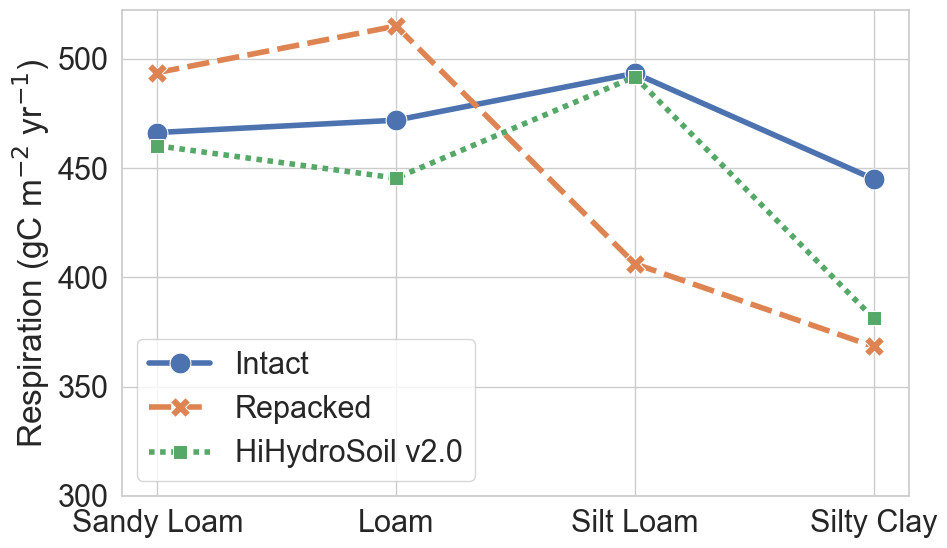

In [7]:
ann_millennialC_millennial,ss_results_millennia_df= get_ann_respiration(new_coloc=new_coloc, default_moisture=False)
ann_millennialC_millennial=ann_millennialC_millennial.reset_index()

soil_order = [ "Sandy Loam","Loam", "Silt Loam", "Silty Clay"]
source_order = ['Intact', 'Repacked', 'HiHydroSoil v2.0']

ann_millennialC_millennial['Soil texture'] = pd.Categorical(ann_millennialC_millennial['Soil texture'], categories=soil_order, ordered=True)
ann_millennialC_millennial['Source'] = pd.Categorical(ann_millennialC_millennial['Source'], categories=source_order, ordered=True)
# Sort by Source first, then Soil texture
ann_millennialC_millennial_sort = ann_millennialC_millennial.sort_values(['Soil texture']).copy()

sns.set_theme(style="whitegrid", font_scale=2)
plt.figure(figsize=(10, 6))

# Line plot with markers
sns.lineplot(
    data=ann_millennialC_millennial_sort,
    x="Soil texture", y="Respiration", hue="Source",
    hue_order=source_order,
    markers=True, style="Source", errorbar="sd",  # or errorbar=None if no error bars
    sort=False,
    estimator="mean",
    err_style="band",
    linewidth=4,
    markersize=15
)
plt.ylim(bottom=300)
plt.xticks(rotation=0)
plt.ylabel("Respiration (gC m$^{-2}$ yr$^{-1}$)")
plt.xlabel("")
# plt.title("Soil Respiration Across Texture Types")
plt.legend(title="", loc='best')
plt.tight_layout()
# Save the plot if needed
plt.savefig('figs/Ann_Respiration_Yan.png', dpi=300, bbox_inches='tight')
plt.savefig('figs/Ann_Respiration_Yan.svg', bbox_inches='tight')
plt.show()


### Steady state C pools

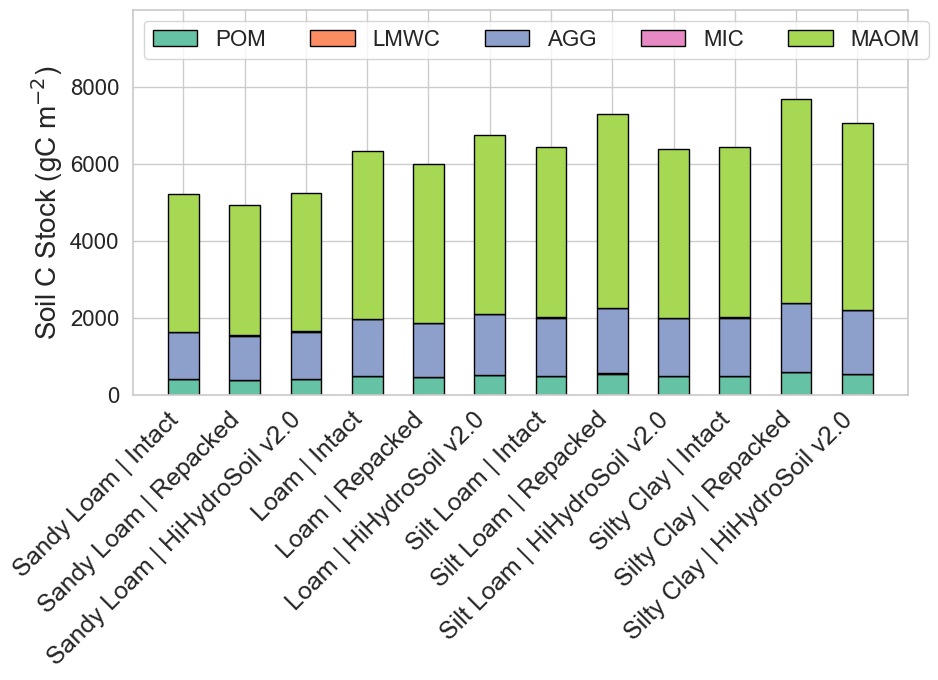

In [8]:
ss_millennial= mll.ss_bar_chart(new_coloc=new_coloc,default_moisture=False, make_plot=False) # Yan 2018 model moisture sensitivity

# Convert to ordered categorical types
pivot_df = ss_millennial.copy()
pivot_df = pivot_df.rename(columns={
    'POM [gC m-2]': r'POM',
    'LMWC [gC m-2]': r'LMWC',
    'AGG [gC m-2]': r'AGG',
    'MIC [gC m-2]': r'MIC',
    'MAOM [gC m-2]': r'MAOM'
})
pool_order =['POM', 'LMWC', 'AGG',  'MIC', 'MAOM']

pivot_df['Source'] = pd.Categorical(pivot_df['Source'], categories=source_order, ordered=True)
pivot_df['Soil texture'] = pd.Categorical(pivot_df['Soil texture'], categories=soil_order, ordered=True)
pivot_df['total_SOC'] = pivot_df[pool_order].sum(axis=1)

pivot_df_sort = pivot_df.sort_values(['Soil texture','Source'])

# Rebuild index for stacked plot
pivot_df_sort.set_index(['Soil texture', 'Source'], inplace=True)

x_labels = [' | '.join(label) for label in pivot_df_sort.index]
x = np.arange(len(x_labels))
pool_order =['POM', 'LMWC', 'AGG',  'MIC', 'MAOM']

# Plotting
fig, ax = plt.subplots(figsize=(10, 5))

bottom = np.zeros(len(pivot_df_sort))
colors = sns.color_palette(n_colors=len(pool_order))
colors = plt.cm.Set2(range(len(pool_order)))
for i, pool in enumerate(pool_order):
    values = pivot_df_sort[pool].values
    ax.bar(x, values, bottom=bottom, label=pool, color=colors[i], edgecolor='black', alpha=1, width=0.5)
    bottom += values

# Aesthetics
ax.set_ylim(0,10000)
ax.set_yticks(np.arange(0, 9001, 2000))
ax.set_yticklabels(ax.get_yticks(), fontsize=16)

ax.set_xticks(x)
ax.set_xticklabels(x_labels, rotation=45, ha='right', fontsize=18)
ax.set_ylabel("Soil C Stock (gC m$^{-2}$)", fontsize=20)
# ax.set_xlabel("Soil texture | Source", fontsize=20)
ax.legend(title="", loc='upper left',  ncol=5, fontsize=16)
# plt.tight_layout()

# plt.tight_layout()

plt.savefig('figs/steady_state_pool_Yan.png', dpi=300, bbox_inches='tight')
plt.savefig('figs/steady_state_pool_Yan.svg', bbox_inches='tight')

In [9]:
pivot_df_sort.index

MultiIndex([('Sandy Loam',           'Intact'),
            ('Sandy Loam',         'Repacked'),
            ('Sandy Loam', 'HiHydroSoil v2.0'),
            (      'Loam',           'Intact'),
            (      'Loam',         'Repacked'),
            (      'Loam', 'HiHydroSoil v2.0'),
            ( 'Silt Loam',           'Intact'),
            ( 'Silt Loam',         'Repacked'),
            ( 'Silt Loam', 'HiHydroSoil v2.0'),
            ('Silty Clay',           'Intact'),
            ('Silty Clay',         'Repacked'),
            ('Silty Clay', 'HiHydroSoil v2.0')],
           names=['Soil texture', 'Source'])

In [10]:
# Define default seaborn color palette (blue, orange, green)
source_order = ['Intact', 'Repacked', 'HiHydroSoil v2.0']
source_colors = dict(zip(source_order, sns.color_palette()[:3]))  # default colors
# Prepare the color list for bars based on Source
bar_colors = [source_colors[source] for _, source in pivot_df_sort.index]
bar_colors

[(0.2980392156862745, 0.4470588235294118, 0.6901960784313725),
 (0.8666666666666667, 0.5176470588235295, 0.3215686274509804),
 (0.3333333333333333, 0.6588235294117647, 0.40784313725490196),
 (0.2980392156862745, 0.4470588235294118, 0.6901960784313725),
 (0.8666666666666667, 0.5176470588235295, 0.3215686274509804),
 (0.3333333333333333, 0.6588235294117647, 0.40784313725490196),
 (0.2980392156862745, 0.4470588235294118, 0.6901960784313725),
 (0.8666666666666667, 0.5176470588235295, 0.3215686274509804),
 (0.3333333333333333, 0.6588235294117647, 0.40784313725490196),
 (0.2980392156862745, 0.4470588235294118, 0.6901960784313725),
 (0.8666666666666667, 0.5176470588235295, 0.3215686274509804),
 (0.3333333333333333, 0.6588235294117647, 0.40784313725490196)]

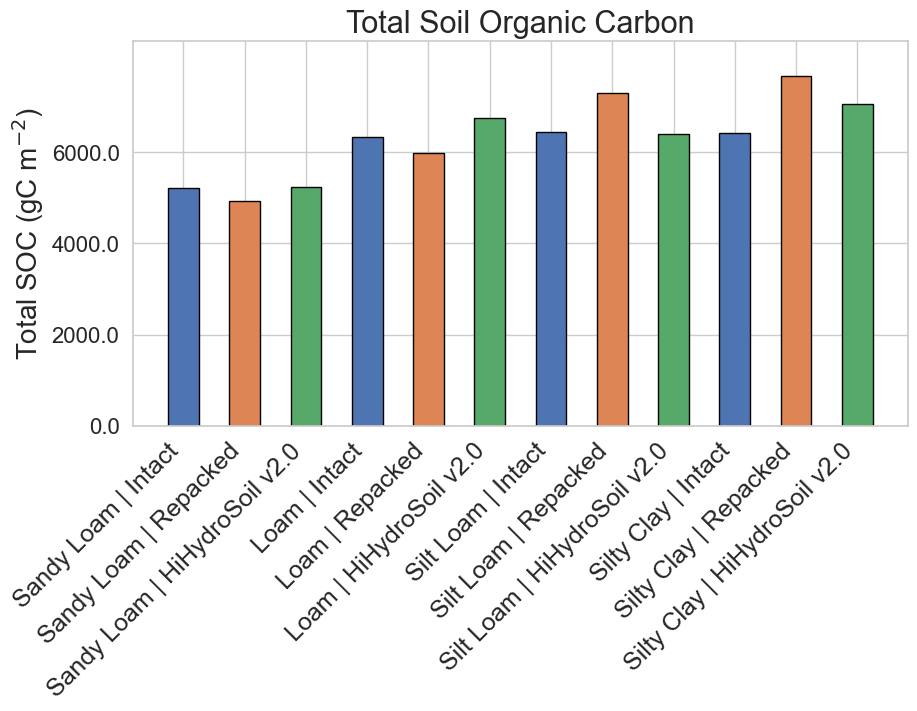

In [11]:

sns.set_theme(style="whitegrid", font_scale=2)
# Bar chart for total SOC
fig, ax = plt.subplots(figsize=(10, 5))
total_SOC_values = pivot_df_sort['total_SOC'].values
ax.bar(x, total_SOC_values,  color=bar_colors, edgecolor='black', alpha=0.99, width=0.5)

# Aesthetics for total SOC chart
ax.set_ylim(0, max(total_SOC_values) * 1.1)
ax.set_yticks(np.arange(0, max(total_SOC_values) + 1, 2000))
ax.set_yticklabels(ax.get_yticks(), fontsize=16)
ax.set_xticks(x)
ax.set_xticklabels(x_labels, rotation=45, ha='right', fontsize=18)
ax.set_ylabel("Total SOC (gC m$^{-2}$)", fontsize=20)
ax.set_title("Total Soil Organic Carbon", fontsize=22)
plt.savefig('figs/total_SOC_Yan.png', dpi=300, bbox_inches='tight')
plt.savefig('figs/total_SOC_Yan.svg', bbox_inches='tight')
plt.show()

In [12]:
pivot_df_sort= pivot_df_sort.reset_index()


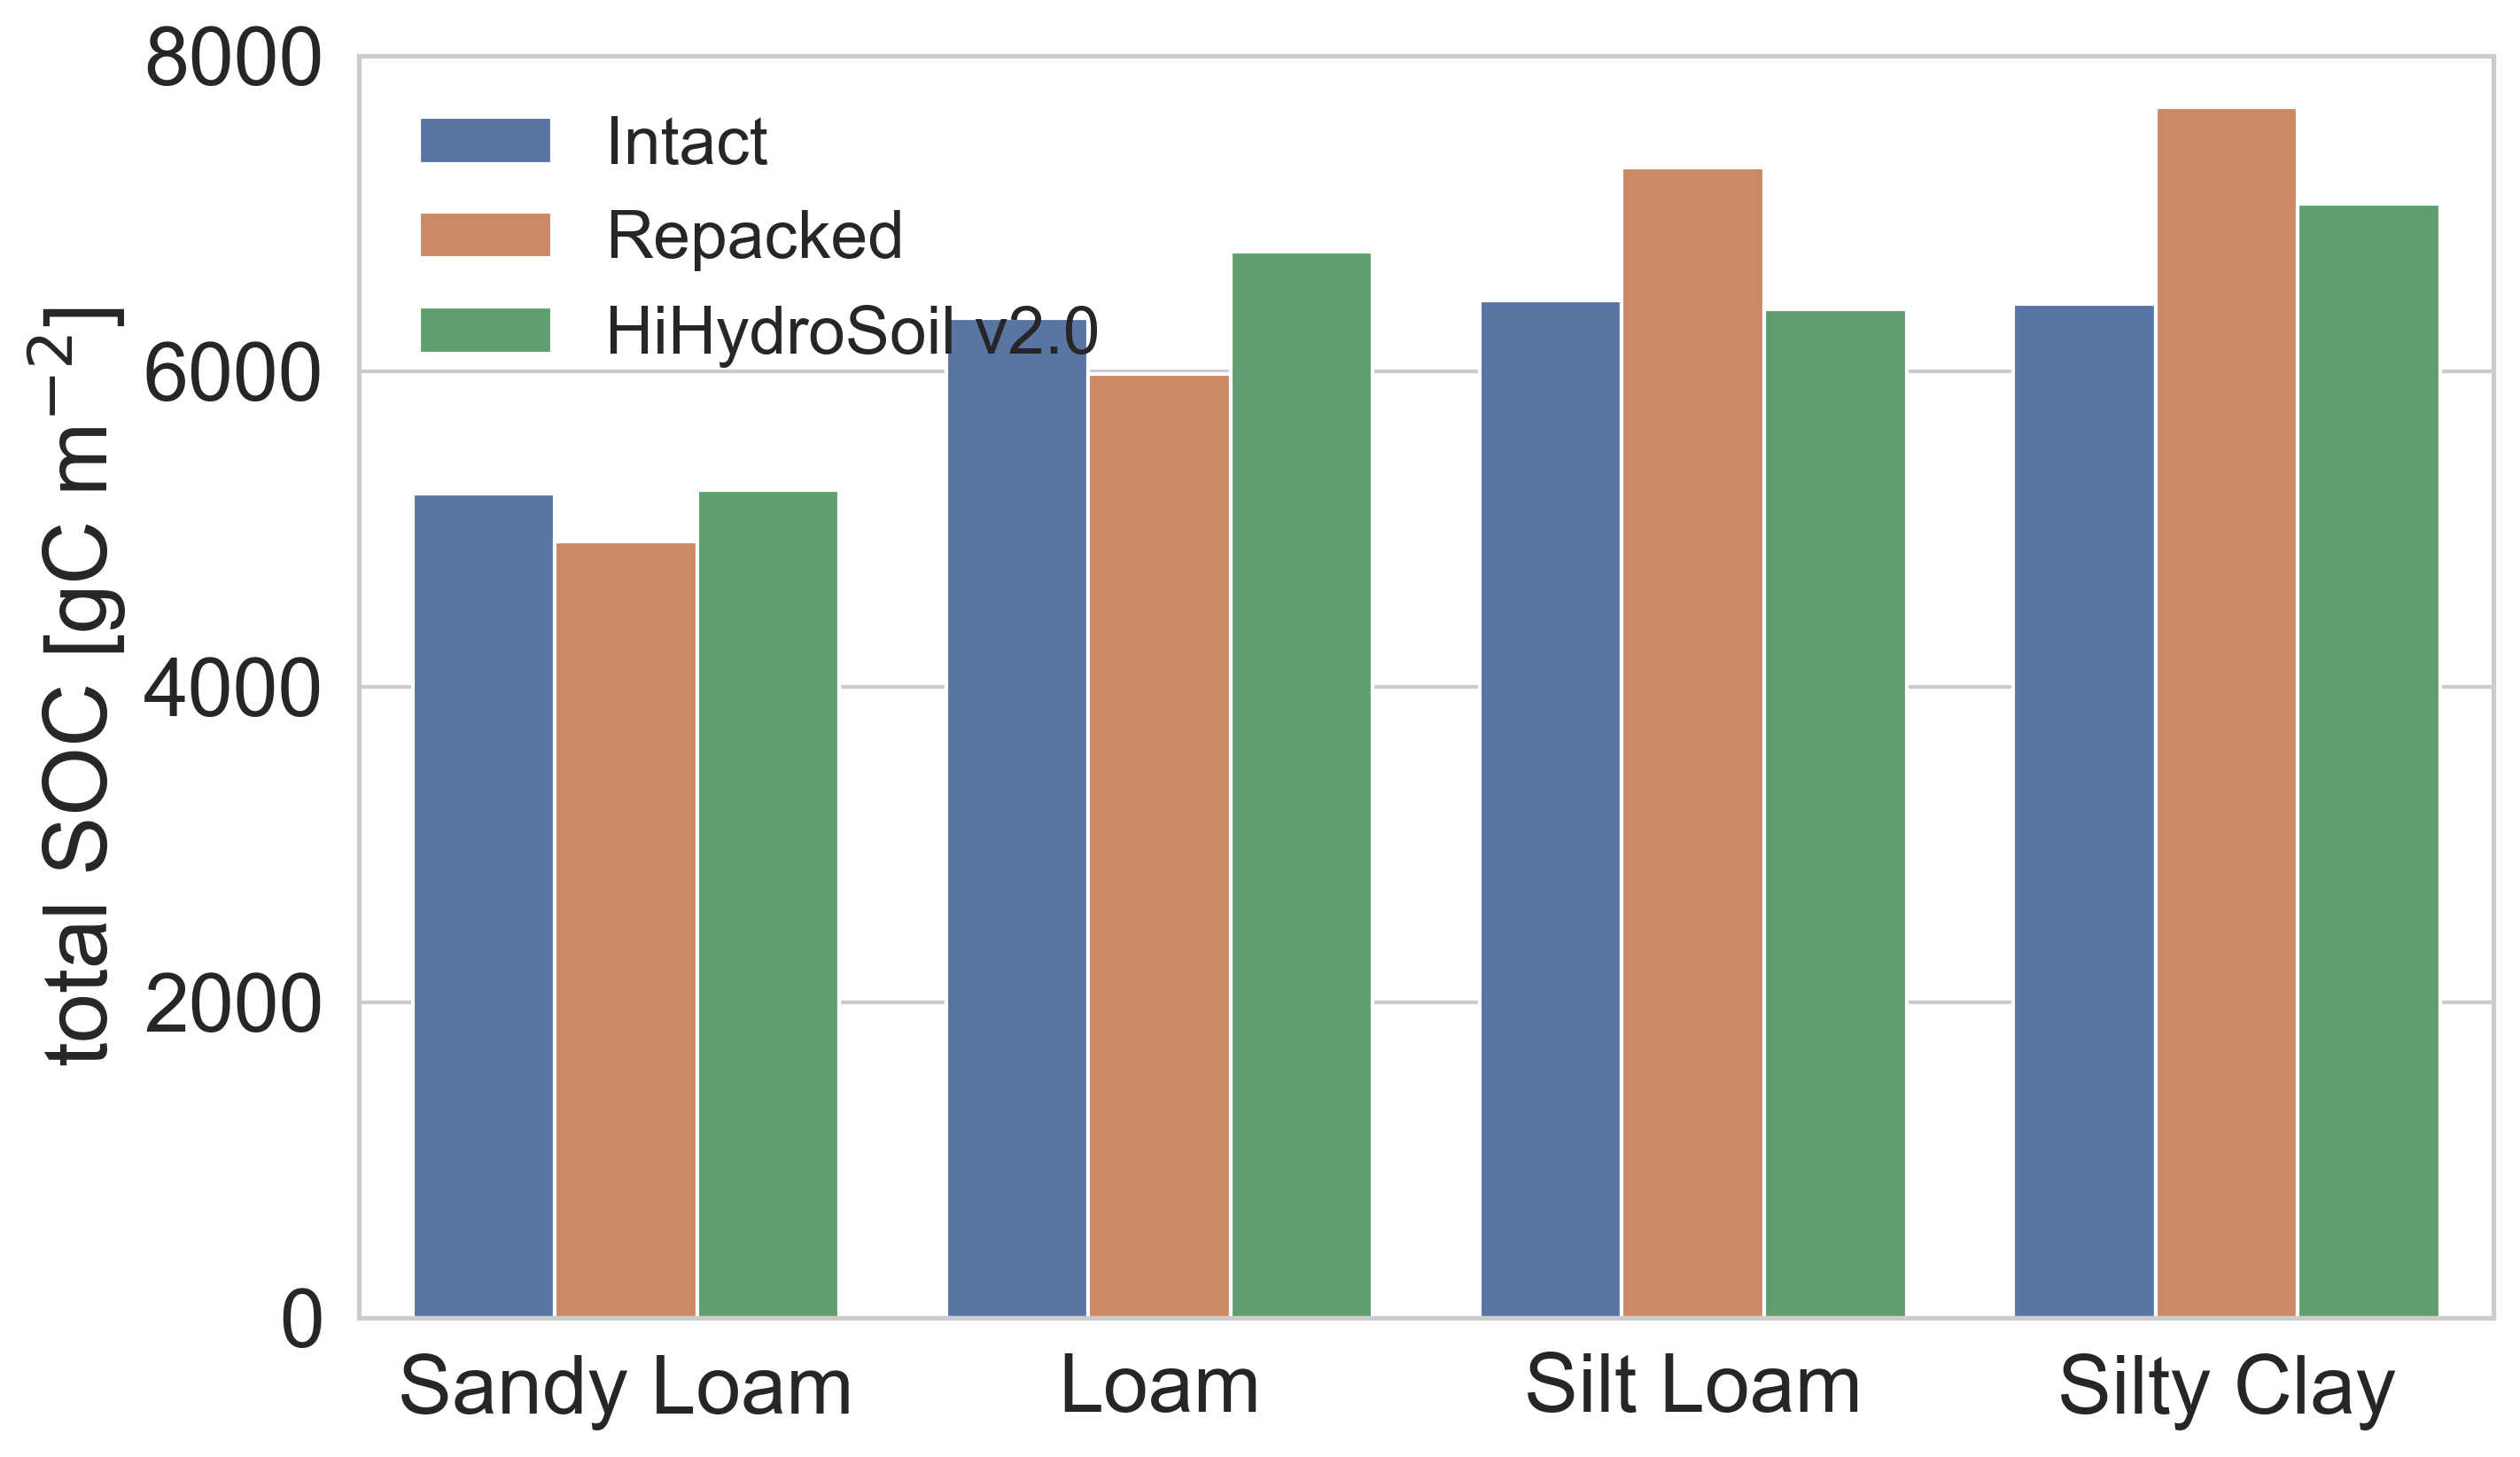

In [13]:
# Filter for only the two desired sources
# filtered_df = pivot_df_sort[
#     pivot_df_sort['Source'].isin(['Intact', 'HiHydroSoil v2.0'])
# ].copy()
# filtered_df['Source'] = filtered_df['Source'].replace({'Intact': 'MONet soil core'})

# Define the custom color palette

sns.set_theme(style="whitegrid", font_scale=2)
plt.figure(figsize=(10, 6), dpi=300)

# Bar plot with error bars showing standard deviation
sns.barplot(
    data=pivot_df_sort,
    x="Soil texture", y="total_SOC", hue="Source",
    hue_order=source_order,
    errorbar="sd",
    estimator="mean",
    )
plt.ylim(bottom=0, top=8000)
plt.xticks(rotation=0)
plt.ylabel("total SOC [gC m$^{-2}$]")
plt.xlabel("")
plt.legend(title="", loc='upper left', ncol=1, fontsize=18, frameon=False)
plt.tight_layout()

plt.savefig('figs/total_SOC_Yan.png', dpi=300, bbox_inches='tight')
plt.savefig('figs/total_SOC_Yan.svg', bbox_inches='tight')
plt.show()


In [14]:
pivot_df[['Soil texture', 'Source','total_SOC']]

,Soil texture,Source,total_SOC
0,Silty Clay,Intact,6428.629795
1,Silty Clay,Repacked,7676.766026
2,Silty Clay,HiHydroSoil v2.0,7063.695828
3,Silt Loam,Intact,6449.553863
4,Silt Loam,Repacked,7293.408759
5,Silt Loam,HiHydroSoil v2.0,6391.187666
6,Loam,Intact,6337.144628
7,Loam,Repacked,5985.355606
8,Loam,HiHydroSoil v2.0,6760.828586
9,Sandy Loam,Intact,5223.067351


In [15]:
pivot_df.loc[pivot_df['Source']=='Repacked','total_SOC'].values

array([7676.76602607, 7293.40875938, 5985.35560637, 4922.72180016])

In [16]:
(pivot_df.loc[pivot_df['Source']=='Intact','total_SOC'].values -  pivot_df.loc[pivot_df['Source']=='Repacked','total_SOC'].values) /  pivot_df.loc[pivot_df['Source']=='Intact','total_SOC'].values*100

array([-19.41527621, -13.08392665,   5.55122287,   5.75036718])

## Soil Moisture over time

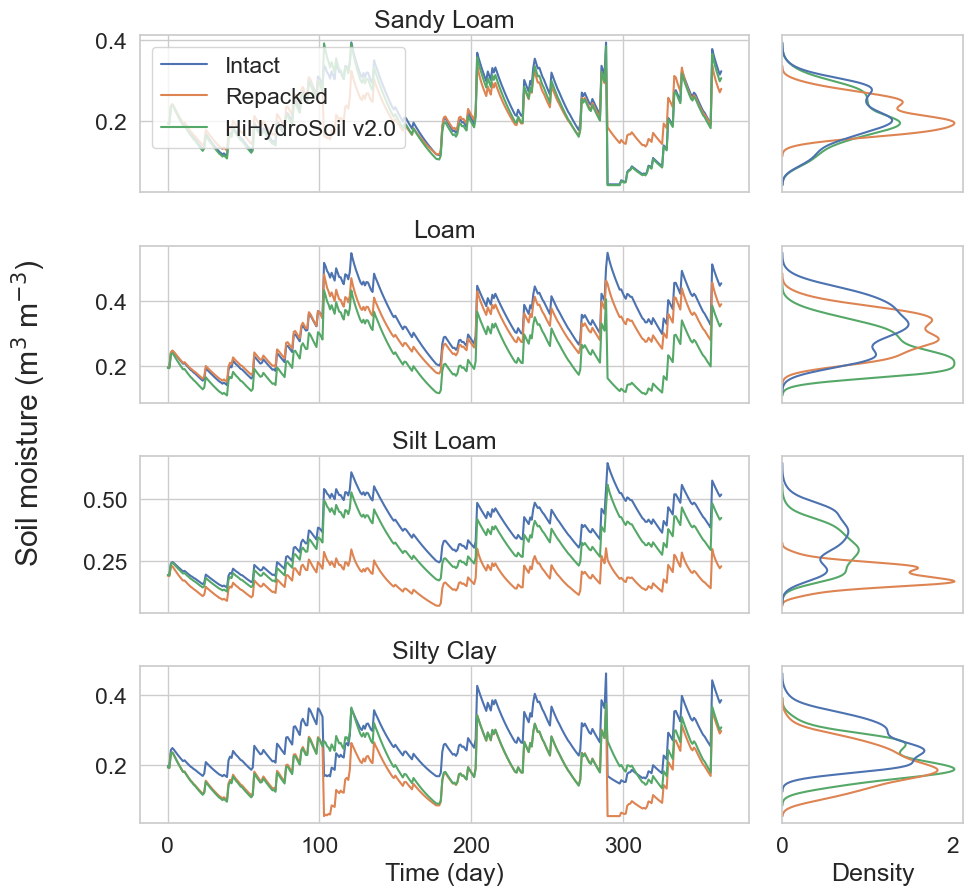

In [17]:

millennialC, ss_results_df, moisture_df= get_daily_respiration(new_coloc=new_coloc, default_moisture=False)

sns.set_theme(style="whitegrid", font_scale=1.5)
n_rows = len(soil_order)
n_cols = 4  # 3 for time-series + 1 for histogram

fig = plt.figure(figsize=(10,10))

# Time-series axes (wide)
ax_theta = [
    plt.subplot2grid((n_rows, n_cols), (i, 0), colspan=3) for i in range(n_rows)
]

# Histogram axes (narrow)
ax_hist = [
    plt.subplot2grid((n_rows, n_cols), (i, 3)) for i in range(n_rows)
]

# Line plots for theta over time
for ax, texture in zip(ax_theta, soil_order):
    subset = moisture_df[moisture_df["Soil texture"] == texture]
    sns.lineplot(data=subset, x="time [day]", y='theta', hue="Source", ax=ax)
    ax.set_ylabel("", fontsize=12)  # label each row by texture
    ax.set_title(texture)  # label each row by texture

    # Remove x-labels for all but bottom row
    if ax != ax_theta[-1]:
        ax.set_xlabel("")
        ax.set_xticklabels([])
    else:
        ax.set_xlabel("Time (day)")

    # Remove legend (can add global one later)
    ax.get_legend().remove()
ax_theta[0].legend(frameon=True, loc='upper left')

# KDE histograms (rotated)
for ax, texture in zip(ax_hist, soil_order):
    subset = moisture_df[moisture_df["Soil texture"] == texture]
    sns.kdeplot(data=subset, y="theta", hue='Source',
                fill=False, linewidth=1.5, ax=ax, legend=False)

    # Clean up ticks and labels
    ax.set_yticks([])
    ax.set_ylabel("")
    ax.grid(False)  # Remove grid lines
    # Only bottom plot gets xlabel
    if ax == ax_hist[-1]:
        ax.set_xlabel("Density")
    else:
        ax.set_xlabel("")
        ax.set_xticklabels([])

# Shared y-axis label for line plots
fig.supylabel(r"Soil moisture (m$^{3}$ m$^{-3}$)")
# fig.suptitle("Soil Moisture Dynamics and Distribution by Texture", fontsize=16, y=0.95)

fig.tight_layout(rect=[0, 0.0, 1, 0.93])  # reserve space for suptitle
plt.savefig('figs/Soil_Moisture_Dynamics.png', dpi=300, bbox_inches='tight')


## plot moisture sensitivities

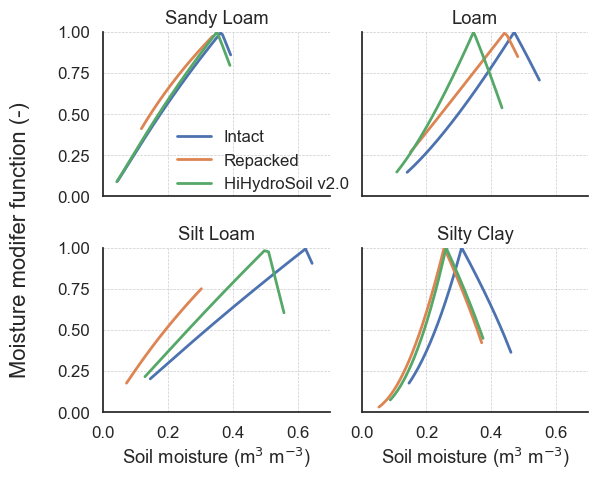

In [18]:
def scalar_wd(phi,theta):
    return (theta / phi) ** (0.5)

spot = np.exp(soil_dict['lambda_val'] * -soil_dict['matpot'])

def sO2(porosity,theta): return (soil_dict['kamin'] + (1 - soil_dict['kamin']) *
                           ((porosity - theta) / porosity)**0.5)
def scalar_wb(phi,theta): return spot * sO2(phi,theta) * \
                                                scalar_wd(phi, theta)

# Prepare the data for plotting
plot_data = []
for _, row in soil_texture.iterrows():
    source = row['source']
    texture = row['texture']
    temp_theta_df = moisture_df[moisture_df['Source'] == source]
    temp_theta_df = temp_theta_df[temp_theta_df['Soil texture'] == texture]

    if  row['source']=='Repacked':
        coloc_factor= new_coloc# Intact soils would have more isolation, higher coloc_factor more isolation
    else:
        coloc_factor=soil_dict['coloc_factor']  #Repacked soils would have less isolation
    
    phi, clay, rel_opt_theta, b, theta_s, theta_r = row[['theta_s', 'Clay', 'Relative_opt_water_content', 'b', 'theta_s', 'theta_r']]
    theta_vals = temp_theta_df['theta'].values
    sat = (theta_vals - theta_s) / (theta_s - theta_r)
    scalar_vals = [mll.Yan2018(theta, phi, clay, coloc_factor, rel_opt_theta, b) for theta in theta_vals]
    scalar_vals_millennial = [scalar_wb(phi, theta) for theta in theta_vals]
    df_temp = pd.DataFrame({
        'theta': theta_vals,
        'Yan2018': scalar_vals,
        'millennial': scalar_vals_millennial,
        'source': source,
        'texture': texture,
        'saturation':sat})
    
    plot_data.append(df_temp)

# Concatenate all data
plot_df = pd.concat(plot_data, ignore_index=True)



# Create FacetGrid
sns.set_theme(style="white", context='paper')
sns.set_context("notebook", font_scale=1.1)

g = sns.FacetGrid(plot_df, col="texture", hue="source", col_wrap=2, 
                  height=2.5, aspect=0.85, sharex=True, sharey=True,
                  col_order=soil_order)
g.map(sns.lineplot, "theta", "Yan2018", linewidth=2,legend=False)

g.set_axis_labels(r"Soil moisture (m$^{3}$ m$^{-3}$)", "")
g.set(xlim=(0, 0.7), ylim=(0, 1))
g.set_titles("{col_name}")  # Show source name in each facet
g.figure.supylabel("Moisture modifer function (-)")
# g.figure.suptitle("(A) Yan et al. (2018)")
g.add_legend(title='', loc='upper right', bbox_to_anchor=(0.6, 0.75))
plt.subplots_adjust(wspace=0.2, top=0.9)
for ax in g.axes.flat:
    ax.grid(True, which='major', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.savefig('figs/Moisture modifer function.png', dpi=300,  bbox_inches='tight')